In [1]:
''' mainly used to make sure that C nmr works better than HSQC'''

import torch
torch.set_printoptions(precision=10)

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from models.optional_input_ranked_transformer import OptionalInputRankedTransformer
from datasets.optional_2d_folder_dataset import OptionalInputDataModule
import yaml
from pytorch_lightning.loggers import TensorBoardLogger
torch.set_float32_matmul_precision('medium')
from pathlib import Path

from rdkit import Chem
from rdkit.Chem import Draw


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load model 

model_path = Path("/root/MorganFP_prediction/reproduce_previous_works/average_3/model_sizes/flexible_384_trail1")
hyperpaerameters_path = model_path / "hparams.yaml"

checkpoint_path = model_path / "checkpoints/epoch=41-step=35994.ckpt"
with open(hyperpaerameters_path, 'r') as file:
    hparams = yaml.safe_load(file)
del hparams['checkpoint_path'] # prevent double defition of checkpoint_path
hparams['use_peak_values'] = False

model = OptionalInputRankedTransformer.load_from_checkpoint(checkpoint_path, **hparams)
model.change_ranker_for_testing()


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


In [3]:
datamodule = OptionalInputDataModule(dir="/workspace/SMILES_dataset", FP_choice=hparams["FP_choice"], input_src=["HSQC", "oneD_NMR"], batch_size=1, parser_args=hparams)

In [4]:
datamodule.setup("predict")

loader_all_inputs, loader_HSQC_H_NMR, loader_HSQC_C_NMR, loader_only_hsqc, loader_only_1d, loader_only_H_NMR, loader_only_C_NMR = \
    datamodule.predict_dataloader()
    
model=model.to("cuda")

In [5]:
# set up ranking set

import pickle 
choice = "test"
fp_path = "R0_to_R4_reduced_FP"
index_to_smiles = pickle.load(open(f'/workspace/SMILES_dataset/{choice}/SMILES/index.pkl', 'rb'))
folder_base = Path("/workspace/SMILES_dataset")

choice_path = folder_base / choice / fp_path
print(f"=== {choice_path}")


all_FP_indices_in_folder = pickle.load(open(f'/root/MorganFP_prediction/reproduce_previous_works/smart4.5/datasets/{choice}_indices_of_full_info_NMRs.pkl', 'rb'))
all_added_smiles = set()
all_FP_indices_to_be_added = []
for i in all_FP_indices_in_folder:
    smile = index_to_smiles [int(i.split(".")[0])]
    if smile not in all_added_smiles:
        all_added_smiles.add(smile)
        all_FP_indices_to_be_added.append(i)
        
sorted_file_indices  = [int(file.split(".")[0]) for file in sorted(all_FP_indices_to_be_added)]
index_to_chemical_names = pickle.load(open(f'/workspace/SMILES_dataset/{choice}/Chemical/index.pkl', 'rb'))

smiles_and_names = [(index_to_smiles[file_index], index_to_chemical_names[file_index]) for file_index in sorted_file_indices]
len(smiles_and_names)


=== /workspace/SMILES_dataset/test/R0_to_R4_reduced_FP


4084

In [6]:
# visualize the all input one 
import os 

chemical_names_lookup = pickle.load(open(f'/workspace/SMILES_dataset/test/Chemical/index.pkl', 'rb'))
# chemical_names_lookup[2288]

In [7]:
all_file_indices = [int(i.split(".")[0]) for i in loader_all_inputs.dataset.files]
all_chemicals = [chemical_names_lookup[file_idx] for file_idx in all_file_indices]
# for i, chemical in enumerate(all_chemicals):
#     print(i, chemical)

In [8]:
which_compound = 5
filename = loader_all_inputs.dataset.files[which_compound]

f_path = os.path.join(loader_all_inputs.dataset.dir, "oneD_NMR", filename)
if os.path.exists(f_path):
    c_tensor, h_tensor = torch.load(f_path)
    
hsqc = torch.load(f_path.replace("oneD_NMR", "HSQC"))

# print(f_path)
chemical_names_lookup = pickle.load(open(f'/workspace/SMILES_dataset/test/Chemical/index.pkl', 'rb'))
chemical_names_lookup[int(filename.split(".")[0])]

'isonaamidine-A'

In [9]:
# import matplotlib.pyplot as plt




# # 
# import matplotlib.gridspec as gridspec


# # Create a 2x2 grid for subplots
# fig = plt.figure(figsize=(6, 4.8))  # Overall figure size
# gs = gridspec.GridSpec(2, 2, height_ratios=[1, 20], width_ratios=[1, 20])

# # Create subplots in different locations and sizes
# pos = hsqc[hsqc[:,2]>0]
# neg = hsqc[hsqc[:,2]<0]
# ax1 = fig.add_subplot(gs[1, 1])  # Takes up the first row
# ax1.scatter(pos[:,1], pos[:,0], c="blue", label="1 or 3 H bond", s=5)
# ax1.scatter(neg[:,1], neg[:,0], c="red", label="2 H bond", s=5)
# ax1.set_title("HSQC")
# ax1.set_xlabel('Proton Shift (H)')  # X-axis label
# ax1.set_xlim([0, 7.5])
# ax1.set_ylim([0, 180])
# ax1.legend()


# ax2 = fig.add_subplot(gs[1, 0])  # Smaller subplot
# ax2.scatter( torch.ones(len(c_tensor)), c_tensor, c="black", s=2)
# ax2.set_ylim([0, 180])
# ax2.set_title("C-NMR")
# ax2.set_ylabel('Carbon Shift (C)')
# ax2.set_xticks([])

# ax3 = fig.add_subplot(gs[0, 1])  # Smaller subplot
# ax3.scatter(h_tensor, torch.ones(len(h_tensor)),c="black", s=2)
# ax3.set_xlim([0, 7.5])
# ax3.set_title("H-NMR")
# ax3.set_yticks([])

# # Adjust layout to prevent overlapping
# plt.tight_layout()

# # Show the plot
# plt.show()



In [10]:
# pred_smile_HSQC, pred_name_HSQC, pred_smile_C, pred_name_C

/root/MorganFP_prediction/reproduce_previous_works/smart4.5/utils/ranker.py:83: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3637.)
  query_products = (self.data @ query.T.squeeze(2))


Occurence 1
Ground truth smiles Brc1cc(Br)c2cc(Br)[nH]c2c1
Chemical name 2,4,6-tribromoindole


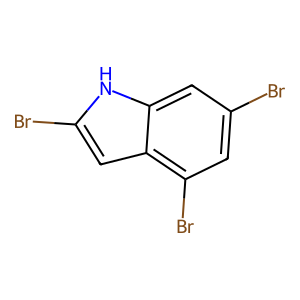

C smiles Brc1cc(Br)c2cc(Br)[nH]c2c1
C name 2,4,6-tribromoindole


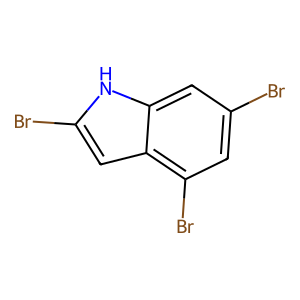

HSQC smiles O=C1c2oc3cc(O)c(O)cc3c2C(=O)c2oc3cc(O)c(O)cc3c21
HSQC name 2,3,8,9-Tetrahydroxybenzo[b][1]benzofuro[2,3-f][1]benzofuran-6,12-dione


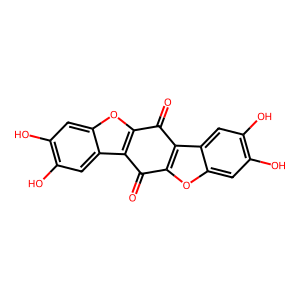

Occurence 2
Ground truth smiles C=C(C)C(O)C(O)c1ccc2c(c1OC)C(=O)OCc1cc(C)cc(O)c1O2
Chemical name pestalotiollide B


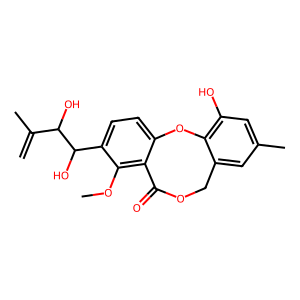

C smiles C=C(C)C(O)C(O)c1ccc2c(c1OC)C(=O)OCc1cc(C)cc(O)c1O2
C name pestalotiollide B


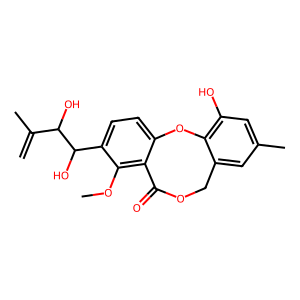

HSQC smiles C=C(C)C1Oc2cc(OC)c(C(C)=O)cc2C1OC(=O)C(C)=CC
HSQC name 71184-02-6


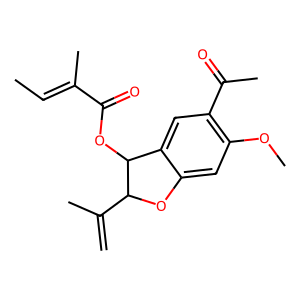

Occurence 3
Ground truth smiles COc1cc(C2Oc3ccc(-c4cc(=O)c5c(O)cc(O)cc5o4)cc3OC2CO)ccc1O
Chemical name (-)-Hydnocarpin


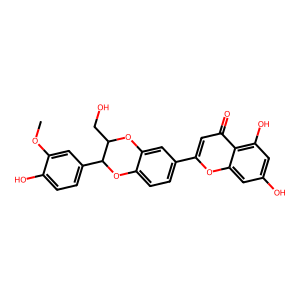

C smiles COc1cc(C2Oc3ccc(-c4cc(=O)c5c(O)cc(O)cc5o4)cc3OC2CO)ccc1O
C name (-)-Hydnocarpin


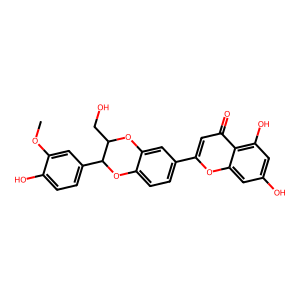

HSQC smiles COc1cc(C2Oc3cc(-c4cc(=O)c5c(O)cc(O)cc5o4)ccc3OC2CO)ccc1O
HSQC name Hydnocarpin


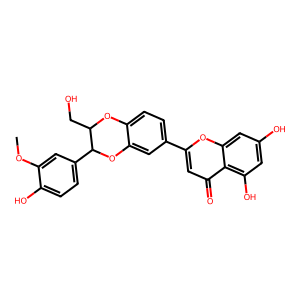

Occurence 4
Ground truth smiles COC(=O)C1(O)CC2CC3C4(C)CC(c5ccoc5)OC(=O)C4CCC31C(=O)O2
Chemical name antadiosbulbin B


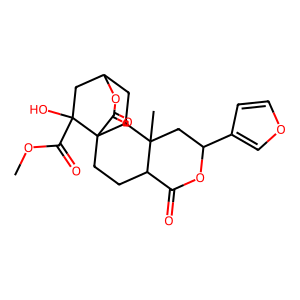

C smiles COC(=O)C1CC2CC3C1(CCC1(O)C(=O)OC(c4ccoc4)CC31C)C(=O)O2
C name bafoudiosbulbin F


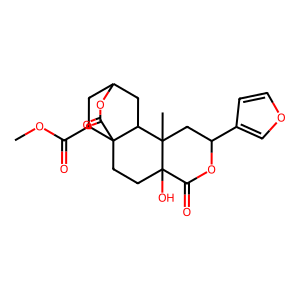

HSQC smiles COC(=O)C1(O)CC2CC3C4(C)CC(c5ccoc5)OC(=O)C4CCC31C(=O)O2
HSQC name antadiosbulbin B


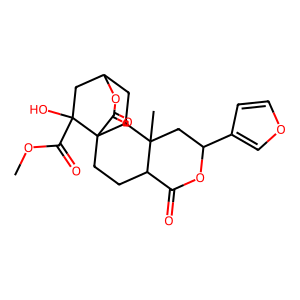

Occurence 5
Ground truth smiles O=C1OCC2=C1NCSC2
Chemical name 4,5-Dihydro-furo[3,4-d][1,3]thiazin-7-one


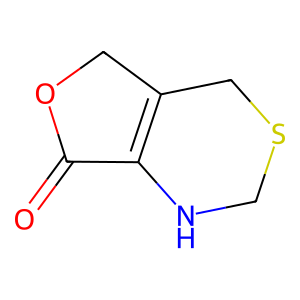

C smiles O=C(OCc1ccccc1)c1ccccc1O
C name Benzyl Salicylate


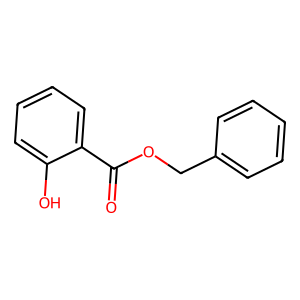

HSQC smiles COC(=O)C1CCC(=O)N1Cc1cc(O)c(O)c(Br)c1Cc1cc(O)c(O)c(Br)c1Br
HSQC name Methyl 1-[3-bromo-2-(2,3-dibromo-4,5-dihydroxybenzyl)-4,5-dihydroxybenzyl]-5-oxoprolinate


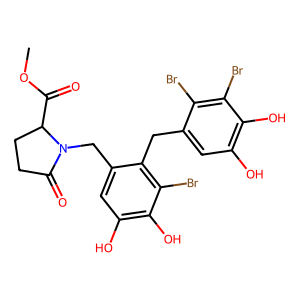

Occurence 6
Ground truth smiles C=C1CCCC2(C)CCC(C=CC(=O)O)CC12O
Chemical name Macrophyllic acid C


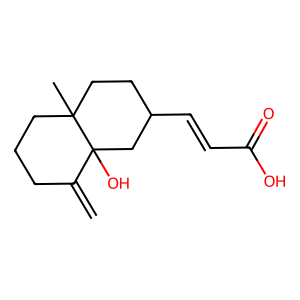

C smiles CC(C)C1CCC2(C)CCCC(=O)C2(C)C1
C name (-)-valeranone


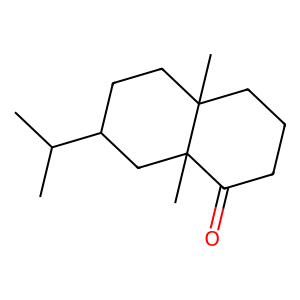

HSQC smiles C=C1CCCC2(C)CCC(C=CC(=O)O)CC12O
HSQC name Macrophyllic acid C


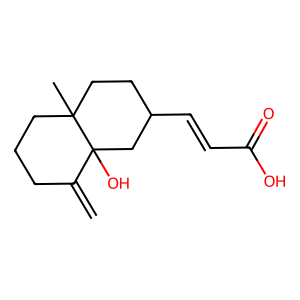

Occurence 7
Ground truth smiles CC1=C(C(C)O)CC(C(C)(O)C2CCC3(O)C4=CC(=O)C5CC(O)C(O)CC5(C)C4CCC23C)OC1=O
Chemical name 24-dehydroprecyasterone


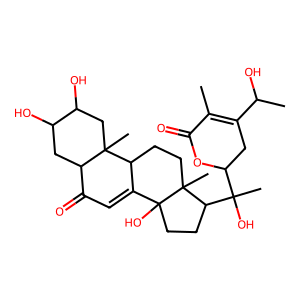

C smiles CC(O)(CO)CCC(O)C(C)(O)C1CCC2(O)C3=CC(=O)C4CC(O)C(O)CC4(C)C3CCC12C
C name NCGC00385426-01!2,3,14-trihydroxy-10,13-dimethyl-17-(2,3,6,7-tetrahydroxy-6-methylheptan-2-yl)-2,3,4,5,9,11,12,15,16,17-decahydro-1H-cyclopenta[a]phenanthren-6-one


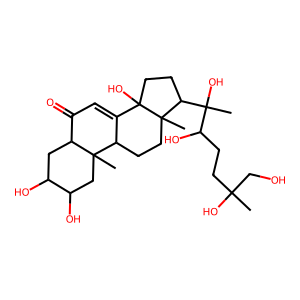

HSQC smiles CC1=C(C(C)O)CC(C(C)(O)C2CCC3(O)C4=CC(=O)C5CC(O)C(O)CC5(C)C4CCC23C)OC1=O
HSQC name 24-dehydroprecyasterone


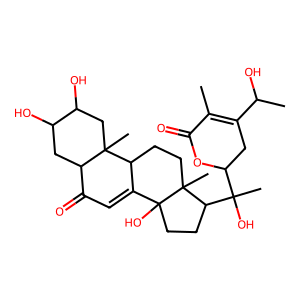

Occurence 8
Ground truth smiles O=c1c2ccccc2nc2n1C(O)Cc1c-2[nH]c2ccccc12
Chemical name 163815-35-8


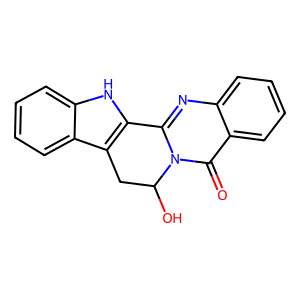

C smiles COn1c(=O)cc2c3ccccc3n3c(=O)ccc1c23
C name 3-Methoxy-3H-indolo[3,2,1-de][1,5]naphthyridine-2,6-dione


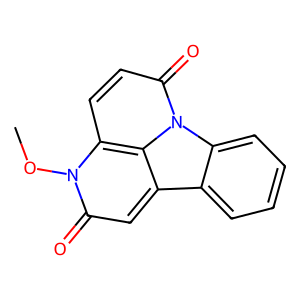

HSQC smiles O=c1c2ccccc2nc2n1C(O)Cc1c-2[nH]c2ccccc12
HSQC name 163815-35-8


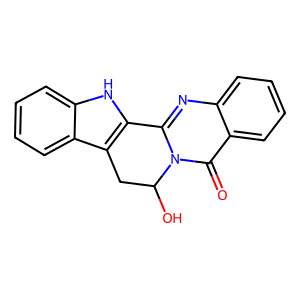

Occurence 9
Ground truth smiles CS(=O)CC(C)(O)C1OC(=O)C=C2C3(C)C4OC4C(O)C4(C)C(=O)OC(C43)C3OC231
Chemical name makilactone P


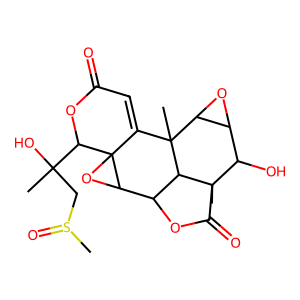

C smiles CS(=O)CC(C)(O)C1OC(=O)C=C2C3(C)C4OC4C(O)C4(C)C(=O)OC(C43)C3OC231
C name makilactone P


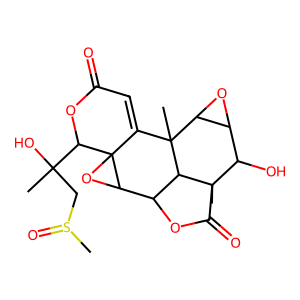

HSQC smiles COC1OC(C(O)CO)C(=Cc2ccc(CO)o2)C1=O
HSQC name PHELLINUSFURAN B


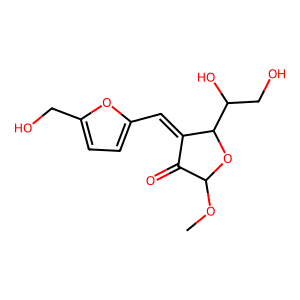

Occurence 10
Ground truth smiles COc1cc2c(c3c1C(=O)CC(c1ccc(O)cc1)O3)C(CC(O)CCc1ccc(O)cc1)CC(c1ccc(O)cc1)O2
Chemical name Calyxin M


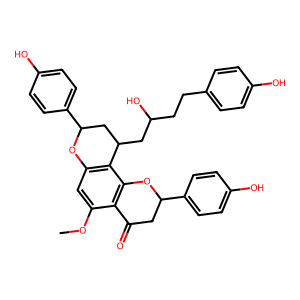

C smiles COc1cc2c(c3c1C(=O)CC(c1ccc(O)cc1)O3)C(CC(O)CCc1ccc(O)cc1)CC(c1ccc(O)cc1)O2
C name Calyxin M


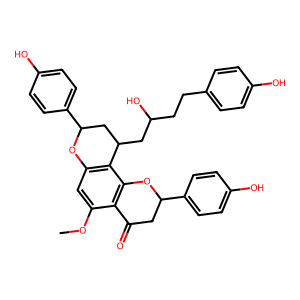

HSQC smiles COc1cc2c(c3c1C(=O)CC(c1ccc(O)cc1)O3)C1CC(CCc3ccc(O)cc3)OC(c3ccc(O)cc3)C1C(c1ccc(O)cc1)O2
HSQC name Calyxin J


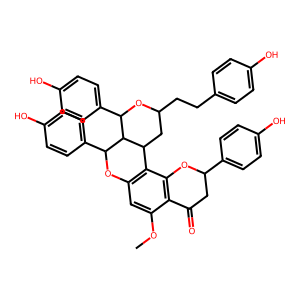

Occurence 11
Ground truth smiles CN1C=NC(C(=O)O)CC1(C)COC(=O)c1ccc[nH]1
Chemical name (4R,6R)-1,6-Dimethyl-6-{[(1H-pyrrol-2-ylcarbonyl)oxy]methyl}-1,4,5,6-tetrahydro-4-pyrimidinecarboxylic acid


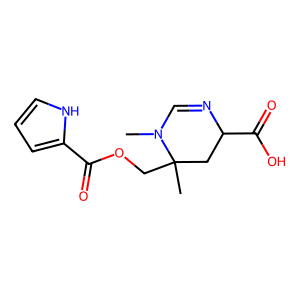

C smiles CN1C=NC(C(=O)O)CC1(C)COC(=O)c1ccc[nH]1
C name (4R,6R)-1,6-Dimethyl-6-{[(1H-pyrrol-2-ylcarbonyl)oxy]methyl}-1,4,5,6-tetrahydro-4-pyrimidinecarboxylic acid


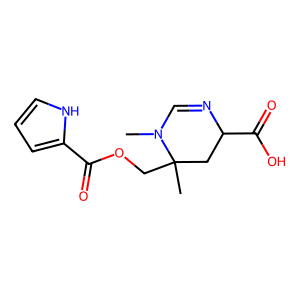

HSQC smiles COc1ccc(CC2NC(=O)C=CCC(CC=Cc3ccccc3)OC(=O)C(CC(C)C)OC(=O)C(C)CNC2=O)cc1Cl
HSQC name (E)-(3S,6R,10R,16R)-10-(3-Chloro-4-Methoxy-Benzyl)-3-Isobutyl-6-Methyl-16-((E)-3-Phenyl-Allyl)-1,4-Dioxa-8,11-Diaza-Cyclohexadec-13-Ene-2,5,9,12-Tetraone


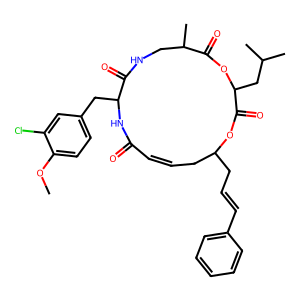

Occurence 12
Ground truth smiles CC1(O)CCC(Cl)C(C)(C)C1CC12OC(C)(C)C(Cl)CC1C(=O)c1c(O)cc(O)cc1C2=O
Chemical name napyradiomycin 6


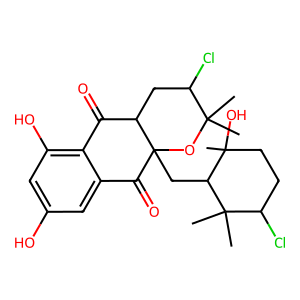

C smiles CC1(O)CCC(Cl)C(C)(C)C1CC12OC(C)(C)C(Cl)CC1C(=O)c1c(O)cc(O)cc1C2=O
C name napyradiomycin 6


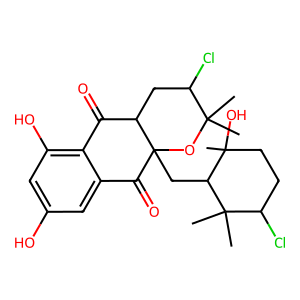

HSQC smiles Cc1cc2c(cc1O)C1(C)CCC(=O)C(C)(C)C1CC2
HSQC name 12-hydroxy-13-methylpodocarpa-9,11,13-trien-3-one


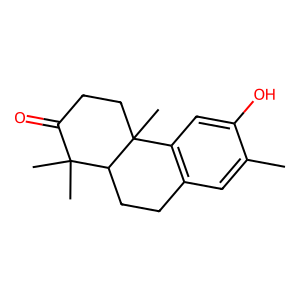

Occurence 13
Ground truth smiles COc1cc2c(cc1OC)Oc1c(O)ccc(CCN(C)C)c1C=C2
Chemical name Secocularidine


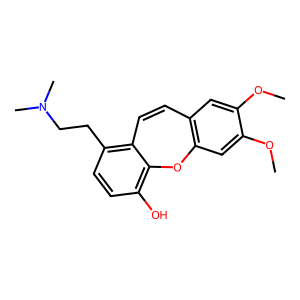

C smiles COc1ccc(-c2cc(=O)c3ccc(O)cc3o2)cc1O
C name 135398025


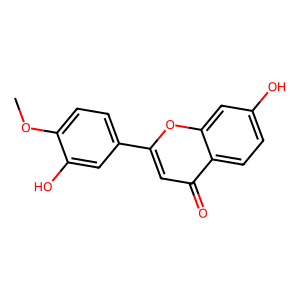

HSQC smiles COc1cc2c(cc1OC)Oc1c(O)ccc(CCN(C)C)c1C=C2
HSQC name Secocularidine


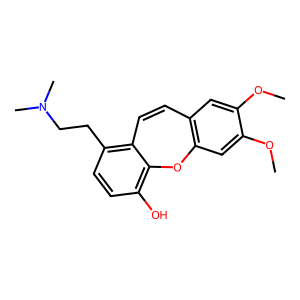

Occurence 14
Ground truth smiles C=C1C(=O)C2OC23CC2CC(C)(C)CC2C13C
Chemical name Desoxyhypnophilin


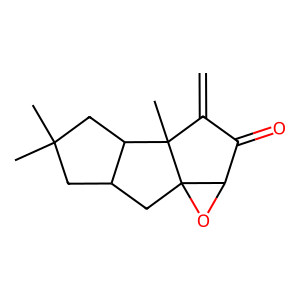

C smiles CC1=CC(=O)C(C2(C)CCC3CC32C)=CC1=O
C name laurequinone


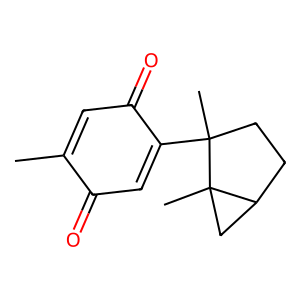

HSQC smiles C=C1C(=O)OC2CC3(CC12)C(C)CCC3(C)CO
HSQC name 90039-69-3


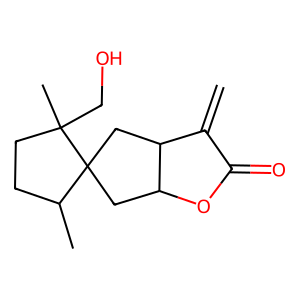

Occurence 15
Ground truth smiles Nc1ccc(S(N)(=O)=O)cc1
Chemical name Sulfanilamide


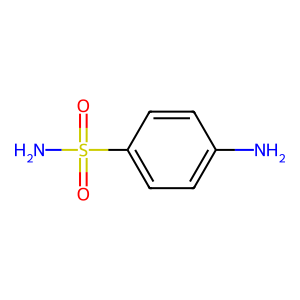

C smiles Oc1c(Br)cccc1Br
C name 2,6-Dibromophenol


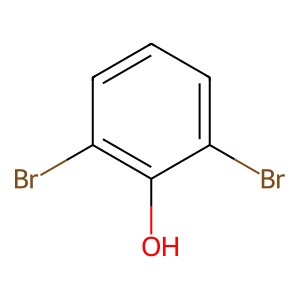

HSQC smiles Nc1ccc(S(N)(=O)=O)cc1
HSQC name Sulfanilamide


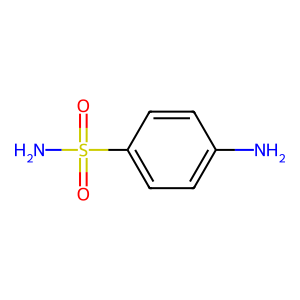

Occurence 16
Ground truth smiles CC1=C2CC(C)(CO)CC2CC2(C)CCC12O
Chemical name Sterpurol A


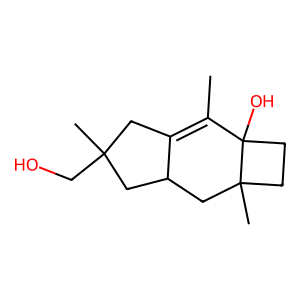

C smiles C=C1C(O)C(O)CC(C)(C)C12CC=C(CO)CC2
C name acaciicolinol F


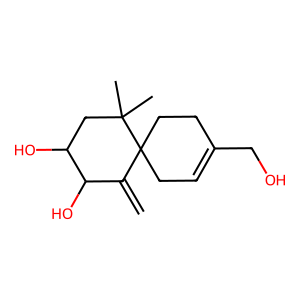

HSQC smiles CC1=C2CC(C)(CO)CC2CC2(C)CCC12O
HSQC name Sterpurol A


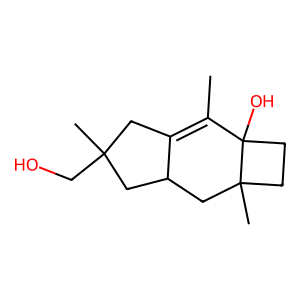

Occurence 17
Ground truth smiles CC(O)c1nc2ccccc2c(=O)[nH]1
Chemical name MEGxm0_000086


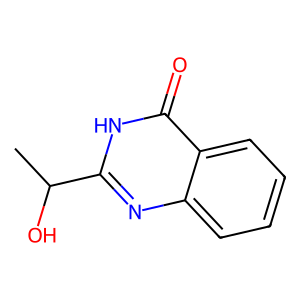

C smiles CC(O)c1nc2ccccc2c(=O)[nH]1
C name MEGxm0_000086


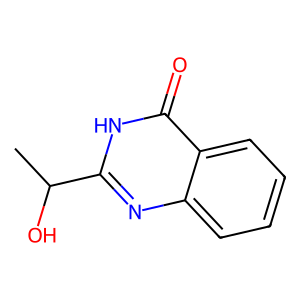

HSQC smiles CC(C)C(=O)c1ccccc1
HSQC name 2-Methyl-1-Phenylpropan-1-One


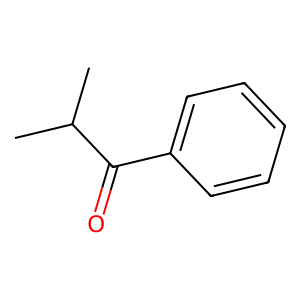

Occurence 18
Ground truth smiles COc1ccc2cc1Oc1ccc(cc1)CC1c3c(cc(OC)c(O)c3Oc3cc4c(cc3OC)CCN=C4C2)CCN1C
Chemical name 103976-35-8


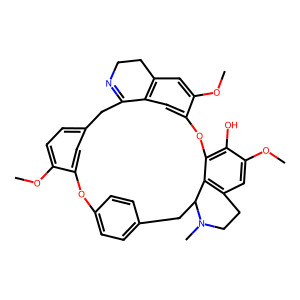

C smiles COc1cc2c3cc1Oc1c(O)c(OC)cc4c1C(Cc1ccc(cc1)Oc1cc(ccc1O)CC3N(C)CC2)N(C)CC4
C name (1alpha)-6,6'-Dimethoxy-2,2'-dimethyloxyacanthan-7,12'-diol


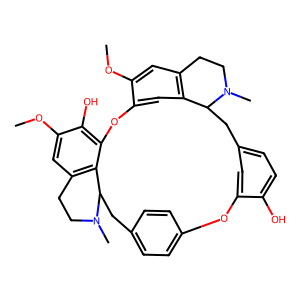

HSQC smiles COc1ccc2cc1Oc1ccc(cc1)CC1c3cc(OC)c(O)c(c3CCN1C)Oc1cc3c(cc1OC)CCN(C)C3C2
HSQC name CHEBI:9514


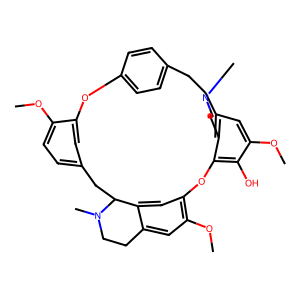

Occurence 19
Ground truth smiles C=C1CCC=C(C)CC=C2C(C(C)C)C(=O)CC2(C)CC1=O
Chemical name dollabella-4(16),7,10-triene-3,13-dione


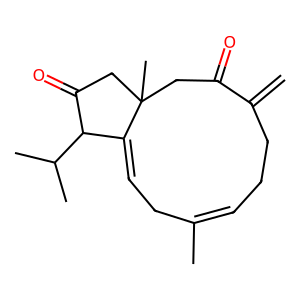

C smiles C=C1CCC=C(C)CC=C2C(C(C)C)C(=O)CC2(C)CC1=O
C name dollabella-4(16),7,10-triene-3,13-dione


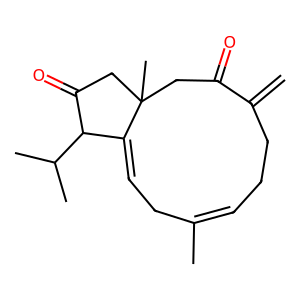

HSQC smiles CC1=CCCC(C)C(=O)CC2=C(C)C(=O)OC2(O)C1
HSQC name NCGC00381360-01_C15H20O4_(9E)-11a-Hydroxy-3,6,10-trimethyl-7,8,11,11a-tetrahydrocyclodeca[b]furan-2,5(4H,6H)-dione


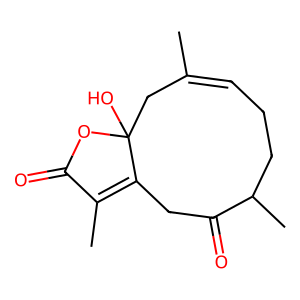

Occurence 20
Ground truth smiles COn1c(=O)cc2c3ccccc3n3c(=O)ccc1c23
Chemical name 3-Methoxy-3H-indolo[3,2,1-de][1,5]naphthyridine-2,6-dione


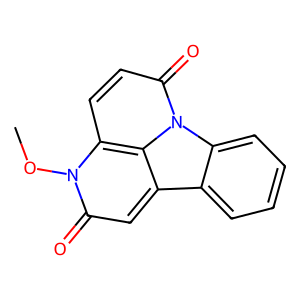

C smiles c1ccc2c(c1)ncc1cc3c(cc12)OCO3
C name Trisphaeridine


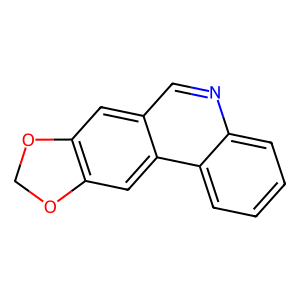

HSQC smiles COn1c(=O)cc2c3ccccc3n3c(=O)ccc1c23
HSQC name 3-Methoxy-3H-indolo[3,2,1-de][1,5]naphthyridine-2,6-dione


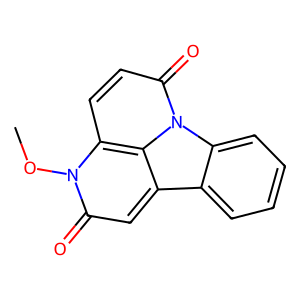

In [11]:
'''Many 0 here because we have batch size 1'''
occurence = 0
for  which_compound in range(80):  


    
    for idx, batch in enumerate(loader_only_hsqc):
        if idx < which_compound:
            continue
        inputs, (smiles_chemical_name) = batch
        
        batch[0] = batch[0].to("cuda")
        topk_idx_HSQC = model.predict_step(batch, idx, dataloader_idx=3)
        break
    pred_smile_HSQC, pred_name_HSQC = smiles_and_names[topk_idx_HSQC[0][0]]


    for idx, batch in enumerate(loader_only_C_NMR):
        if idx < which_compound:
            continue
        inputs, (smiles_chemical_name) = batch
        
        batch[0] = batch[0].to("cuda")
        topk_idx_C_nmr = model.predict_step(batch, idx, dataloader_idx=6)
        # if idx <= 1: continue
        break
    pred_smile_C, pred_name_C = smiles_and_names[topk_idx_C_nmr[0][0]]
    
   


    if pred_smile_C!=pred_smile_HSQC:
        occurence+=1
        print(f"Occurence {occurence}")
        smiles, names = zip(*smiles_chemical_name)
        mol = Chem.MolFromSmiles(smiles[0])
        print(f"Ground truth smiles {smiles[0]}")
        print(f"Chemical name {names[0]}")
        img = Draw.MolToImage(mol)
        img.show()
        mol = Chem.MolFromSmiles(pred_smile_C)
        print(f"C smiles {pred_smile_C}")
        print(f"C name {pred_name_C}")
        img = Draw.MolToImage(mol)
        img.show()
        mol = Chem.MolFromSmiles(pred_smile_HSQC)
        print(f"HSQC smiles {pred_smile_HSQC}")
        print(f"HSQC name {pred_name_HSQC}")
        img = Draw.MolToImage(mol)
        img.show()


In [12]:
'''demo all inputs'''
# for idx, batch in enumerate(loader_all_inputs):
#     inputs, (smiles_chemical_name) = batch
    
#     batch[0] = batch[0].to("cuda")
#     topk_idx_all_spec = model.predict_step(batch, idx, dataloader_idx=0)
#     # if idx <= 1: continue
#     break

'demo all inputs'

In [13]:
'''demo C'''

# for idx, batch in enumerate(loader_only_C_NMR):
#     inputs, (smiles_chemical_name) = batch
    
#     batch[0] = batch[0].to("cuda")
#     topk_idx_C_nmr = model.predict_step(batch, idx, dataloader_idx=6)
#     # if idx <= 1: continue
#     break

'demo C'

In [14]:
'''demo hsqc'''

# for idx, batch in enumerate(loader_only_hsqc):
#     inputs, (smiles_chemical_name) = batch
    
#     batch[0] = batch[0].to("cuda")
#     topk_idx_HSQC = model.predict_step(batch, idx, dataloader_idx=3)
#     # if idx <= 1: continue
#     break

'demo hsqc'

In [15]:
# """demo day: trying to show some results"""

# smiles, names = zip(*smiles_chemical_name)
# for i in range(len(smiles)):
#     print()
#     mol = Chem.MolFromSmiles(smiles[i])

#     # print("compound number", i+1)
#     print(f"Ground truth smiles {smiles[i]}")
#     print(f"Chemical name {names[i]}")
#     img = Draw.MolToImage(mol)
#     img.show()
    
#     for idx in range(2):
#         # pred_smile, pred_name = smiles_and_names[topk_idx_all_spec[idx][i]]
#         # print(f"Following is top-{idx+1} prediction using all three spectra: {pred_name}, smiles: {pred_smile}")
#         # mol = Chem.MolFromSmiles(pred_smile)
#         # img = Draw.MolToImage(mol)
#         # img.show()
        
#         pred_smile, pred_name = smiles_and_names[topk_idx_C_nmr[idx][i]]
#         print(f"Following is top-{idx+1} prediction using only C NMR: {pred_name}, smiles: {pred_smile}")
#         mol = Chem.MolFromSmiles(pred_smile)
#         img = Draw.MolToImage(mol)
#         img.show()
        
#         # pred_smile, pred_name = smiles_and_names[topk_idx_HSQC[idx][i]]
#         # print(f"Following is top-{idx+1} prediction using only HSQC: {pred_name}, smiles: {pred_smile}")
#         # mol = Chem.MolFromSmiles(pred_smile)
#         # img = Draw.MolToImage(mol)
#         # img.show()
        
#     print("===")

In [16]:
# k = 5

# for idx, batch in enumerate(loader_all_inputs):
#     inputs, (smiles_chemical_name) = batch
    
#     batch[0] = batch[0].to("cuda")
#     topk_idx_all_spec = model.predict_step(batch, idx, dataloader_idx=0)
#     if idx <= k: continue
#     break

# for idx, batch in enumerate(loader_only_C_NMR):
#     inputs, (smiles_chemical_name) = batch
    
#     batch[0] = batch[0].to("cuda")
#     topk_idx_C_nmr = model.predict_step(batch, idx, dataloader_idx=6)
#     if idx <= k: continue
#     break

# for idx, batch in enumerate(loader_only_hsqc):
#     inputs, (smiles_chemical_name) = batch
    
#     batch[0] = batch[0].to("cuda")
#     topk_idx_HSQC = model.predict_step(batch, idx, dataloader_idx=3)
#     if idx <= k: continue
#     break


# smiles, names = zip(*smiles_chemical_name)
# for i in range(len(smiles)):
#     print()
#     mol = Chem.MolFromSmiles(smiles[i])

#     print("compound number", i+1)
#     print(f"Ground truth smiles {smiles[i]}")
#     print(f"Chemical name {names[i]}")
#     img = Draw.MolToImage(mol)
#     img.show()
    
#     for idx in range(1):
#         pred_smile, pred_name = smiles_and_names[topk_idx_all_spec[idx][i]]
#         print(f"Following is top-{idx+1} prediction using all three spectra: {pred_name}, smiles: {pred_smile}")
#         mol = Chem.MolFromSmiles(pred_smile)
#         img = Draw.MolToImage(mol)
#         img.show()
        
#         pred_smile, pred_name = smiles_and_names[topk_idx_C_nmr[idx][i]]
#         print(f"Following is top-{idx+1} prediction using only C NMR: {pred_name}, smiles: {pred_smile}")
#         mol = Chem.MolFromSmiles(pred_smile)
#         img = Draw.MolToImage(mol)
#         img.show()
        
#         pred_smile, pred_name = smiles_and_names[topk_idx_HSQC[idx][i]]
#         print(f"Following is top-{idx+1} prediction using only HSQC: {pred_name}, smiles: {pred_smile}")
#         mol = Chem.MolFromSmiles(pred_smile)
#         img = Draw.MolToImage(mol)
#         img.show()
        
#     print("===")